# Geocoding Building Permit Data

Geocoding is the process of taking an address string e.g. "123 Main St" and converting it to an X,Y coordinate that we can map / use for spatial analysis

Let's learn how to geocode addresses via Nominatim, the free to use geocoder for OpenStreetMap.

We'll be using cleared Building Permit data from the City of Toronto's Open Data catalogue: https://open.toronto.ca/dataset/building-permits-cleared-permits-current-year/

In [3]:
import pandas as pd
import geopandas as gpd
import time

In [4]:
df = pd.read_csv("clearedpermits_current_year_csv.csv")

Geocoding can take a while, so let's just work with a subset of this data. I'm personally interested in Laneway housing, so I'm going to subset for any new Laneway housing that has been built in the past year

In [7]:
df = df.loc[df["WORK"] == 'New Laneway / Rear Yard Suite']
df.head()

PERMIT_NUM  REVISION_NUM                 PERMIT_TYPE  \
2023  17 248012 BLD             0  Small Residential Projects   
3023  19 207174 BLD             1  Small Residential Projects   
3024  19 207174 BLD             0  Small Residential Projects   
3025  19 207174 BLD             2  Small Residential Projects   
3291  19 255117 BLD             1  Small Residential Projects   

                 STRUCTURE_TYPE                           WORK STREET_NUM  \
2023  Laneway / Rear Yard Suite  New Laneway / Rear Yard Suite        441   
3023  Laneway / Rear Yard Suite  New Laneway / Rear Yard Suite        376   
3024  Laneway / Rear Yard Suite  New Laneway / Rear Yard Suite        376   
3025  Laneway / Rear Yard Suite  New Laneway / Rear Yard Suite        376   
3291  Laneway / Rear Yard Suite  New Laneway / Rear Yard Suite        107   

     STREET_NAME STREET_TYPE STREET_DIRECTION POSTAL  ...  \
2023    MONTROSE         AVE                     M6G  ...   
3023      SUMACH          ST                     M4X  ...   
3024      SUMACH          ST                     M4X  ...   
3025      SUMACH          ST                     M4X  ...   
3291  STRATHMORE        BLVD                     M4J  ...   

      DWELLING_UNITS_LOST EST_CONST_COST  ASSEMBLY  INSTITUTIONAL  \
2023                  0.0          15000       0.0              0   
3023                  0.0              0       0.0              0   
3024                  0.0         300000       0.0              0   
3025                  0.0              0       0.0              0   
3291                  0.0              0       0.0              0   

      RESIDENTIAL BUSINESS_AND_PERSONAL_SERVICES MERCANTILE INDUSTRIAL  \
2023        89.53                            0.0        0.0        0.0   
3023         0.00                            0.0        0.0        0.0   
3024       113.00                            0.0        0.0        0.0   
3025         0.00                            0.0        0.0        0.0   
3291         0.00                            0.0        0.0        0.0   

     INTERIOR_ALTERATIONS  DEMOLITION  
2023                  0.0         0.0  
3023                  0.0         0.0  
3024                  0.0         0.0  
3025                  0.0         0.0  
3291                  0.0         0.0  

[5 rows x 30 columns]

We can see in the table above that we have columns for the address (street name, type, and number), but no spatial coordinates!

Let's create a Python function that reads in an address and geocodes it!

This uses the `reqeusts` library to query the Nominatim API, and then the `json` to parse the output into a Python dictionary.

In [8]:
import requests
import json

def geocode(address):

    try:
        
        address_full = address 

        url = "https://nominatim.openstreetmap.org/search/" + address + "?format=json&addressdetails=2&limit=5"

        page = requests.get(url)

        data = json.loads(page.content)
        
        # return data # switch this out with the next line if you want to see the full data that is being returned

        return(data[0]['lon'], data[0]['lat'])
    
    except:
        
        return(0,0)
                             
data = geocode('Toronto')
data

('-79.3839347', '43.6534817')

Now let's loop over the dataframe, trying to geocode each row:

In [9]:
%%time

coordinates = []
addresses = []

for index, row in df.iterrows():
    
    street_number = row["STREET_NUM"]
    street_name = row["STREET_NAME"]
    street_type = row["STREET_TYPE"]
    street_dir = row["STREET_DIRECTION"]
    
    address = street_number + " " + street_name + " " + street_type + " " + street_dir + "Toronto, Canada"
    
    if address not in addresses:
        
        print(address)
        
        addresses.append(address)
    
        data = geocode(address)

        # we can't send too many requests, not more than 1 per second
        time.sleep(1)

        coordinates.append([row["PERMIT_NUM"], address, data[0], data[1]])
    

441 MONTROSE AVE  Toronto, Canada
376 SUMACH ST  Toronto, Canada
107 STRATHMORE BLVD  Toronto, Canada
58 ST CLARENS AVE  Toronto, Canada
95 MACKAY AVE  Toronto, Canada
60 WINCHESTER ST  Toronto, Canada
104 PEMBROKE ST  Toronto, Canada
200 HEWARD AVE  Toronto, Canada
82 MAJOR ST  Toronto, Canada
158 RANDOLPH RD  Toronto, Canada
281 A OSLER ST  Toronto, Canada
29 GRACE ST  Toronto, Canada
15 HECTOR AVE  Toronto, Canada
80 PRESCOTT AVE  Toronto, Canada
11 ROSE AVE  Toronto, Canada
147 DENISON AVE  Toronto, Canada
165 MANNING AVE  Toronto, Canada
367 HOWLAND AVE  Toronto, Canada
369 HOWLAND AVE  Toronto, Canada
48 LANARK AVE  Toronto, Canada
254 RIVERDALE AVE  Toronto, Canada
15 ELM GROVE AVE  Toronto, Canada
169 CONCORD AVE  Toronto, Canada
564 BERESFORD AVE  Toronto, Canada
106 WRIGHT AVE  Toronto, Canada
148 BORDEN ST  Toronto, Canada
76 SYMINGTON AVE  Toronto, Canada
396 WOODBINE AVE  Toronto, Canada
329 RYDING AVE  Toronto, Canada
227 WINDERMERE AVE  Toronto, Canada
9 HUGO AVE  Toront

We can save the output as a csv or convert it to geopandas GeoDataFrame (which could be further saved as a .geojson or any other spatial format)

In [71]:
dfc = pd.DataFrame(coordinates, columns = ['PERMIT_NUM', 'address', 'X', 'Y'])

In [74]:
dfc.to_csv("geocoded-building-permits.csv")

In [80]:
dfc = gpd.GeoDataFrame(dfc, geometry=gpd.points_from_xy(dfc.X, dfc.Y))
dfc

PERMIT_NUM                               address                   X  \
0   17 248012 BLD     441 MONTROSE AVE  Toronto, Canada   -79.4204612512195   
1   19 207174 BLD        376 SUMACH ST  Toronto, Canada  -79.36306036666667   
2   19 255117 BLD  107 STRATHMORE BLVD  Toronto, Canada         -79.3353295   
3   20 134148 BLD    58 ST CLARENS AVE  Toronto, Canada        -79.43789606   
4   20 159667 BLD        95 MACKAY AVE  Toronto, Canada  -79.44643031999999   
5   20 167921 BLD     60 WINCHESTER ST  Toronto, Canada  -79.36794392857142   
6   20 185670 BLD      104 PEMBROKE ST  Toronto, Canada         -79.3732215   
7   21 113763 BLD       200 HEWARD AVE  Toronto, Canada  -79.33896060444444   
8   21 120719 BLD          82 MAJOR ST  Toronto, Canada  -79.40418652608696   
9   21 128247 BLD      158 RANDOLPH RD  Toronto, Canada  -79.36360876676692   
10  21 135543 BLD       281 A OSLER ST  Toronto, Canada         -79.4569785   
11  21 147550 BLD          29 GRACE ST  Toronto, Canada         -79.4140697   
12  21 184922 BLD        15 HECTOR AVE  Toronto, Canada  -79.42354894500001   
13  21 189446 BLD      80 PRESCOTT AVE  Toronto, Canada          -79.458095   
14  21 197266 BLD          11 ROSE AVE  Toronto, Canada  -79.36997712857142   
15  21 203532 BLD      147 DENISON AVE  Toronto, Canada          -79.402289   
16  21 205021 BLD      165 MANNING AVE  Toronto, Canada         -79.4104623   
17  21 209366 BLD      367 HOWLAND AVE  Toronto, Canada          -79.413007   
18  21 209376 BLD      369 HOWLAND AVE  Toronto, Canada         -79.4087899   
19  21 214146 BLD        48 LANARK AVE  Toronto, Canada  -79.44135148421053   
20  21 221005 BLD    254 RIVERDALE AVE  Toronto, Canada  -79.34284330424676   
21  21 221679 BLD     15 ELM GROVE AVE  Toronto, Canada     -79.43036733125   
22  21 243859 BLD      169 CONCORD AVE  Toronto, Canada  -79.42552454590164   
23  21 249621 BLD    564 BERESFORD AVE  Toronto, Canada   -79.4818790978511   
24  21 250938 BLD       106 WRIGHT AVE  Toronto, Canada   -79.4452692056234   
25  22 102957 BLD        148 BORDEN ST  Toronto, Canada  -79.40682164615384   
26  22 122924 BLD     76 SYMINGTON AVE  Toronto, Canada   -79.4487087451613   
27  22 128882 BLD     396 WOODBINE AVE  Toronto, Canada  -79.30768446956522   
28  22 138723 BLD       329 RYDING AVE  Toronto, Canada  -79.48164094444445   
29  22 159161 BLD   227 WINDERMERE AVE  Toronto, Canada  -79.47803188571429   
30  22 160421 BLD           9 HUGO AVE  Toronto, Canada  -79.45331532222222   
31  22 217078 BLD      85 SUPERIOR AVE  Toronto, Canada  -79.49247764347827   
32  22 229450 BLD         72 WARREN RD  Toronto, Canada  -79.40625045454546   
33  22 237961 BLD    317 SUTHERLAND DR  Toronto, Canada       -79.365225725   
34  22 238574 BLD    47 INNISMORE CRES  Toronto, Canada         -79.3027047   
35  23 117996 BLD        135 EVANS AVE  Toronto, Canada  -79.48554502173913   
36  23 132712 000         41 ALGOMA ST  Toronto, Canada  -79.49527136494677   

                     Y                    geometry  
0   43.662193107317066  POINT (-79.42046 43.66219)  
1   43.666405733333335  POINT (-79.36306 43.66641)  
2           43.6816281  POINT (-79.33533 43.68163)  
3          43.64847238  POINT (-79.43790 43.64847)  
4          43.67622847  POINT (-79.44643 43.67623)  
5    43.66620375714286  POINT (-79.36794 43.66620)  
6           43.6598523  POINT (-79.37322 43.65985)  
7   43.660815086666666  POINT (-79.33896 43.66082)  
8    43.66038156086957  POINT (-79.40419 43.66038)  
9    43.70709537268029  POINT (-79.36361 43.70710)  
10          43.6653391  POINT (-79.45698 43.66534)  
11          43.6516041  POINT (-79.41407 43.65160)  
12         43.67468325  POINT (-79.42355 43.67468)  
13  43.676913345454544  POINT (-79.45810 43.67691)  
14   43.66594875714286  POINT (-79.36998 43.66595)  
15           43.652661  POINT (-79.40229 43.65266)  
16          43.6504894  POINT (-79.41046 43.65049)  
17          43.6762186  POINT (-79.41301 43.67622)

<Axes: >

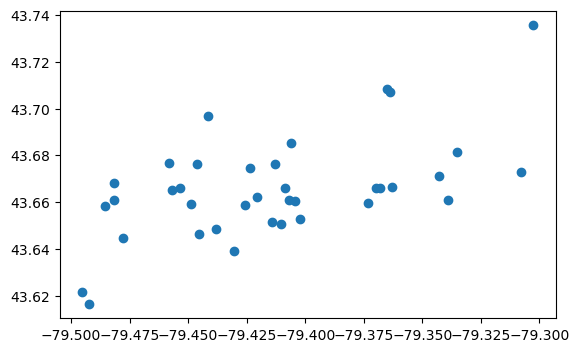

In [79]:
dfc.plot()